In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

In [3]:
data = pd.read_csv('Breast_cancer_data.csv')

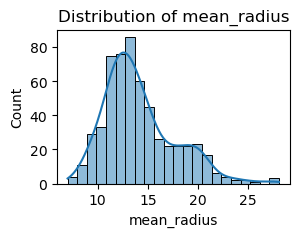

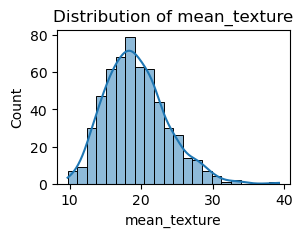

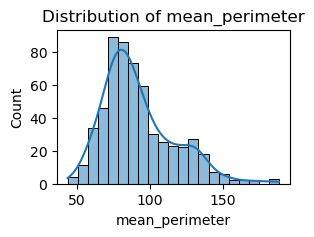

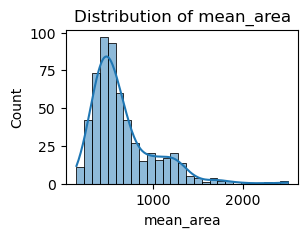

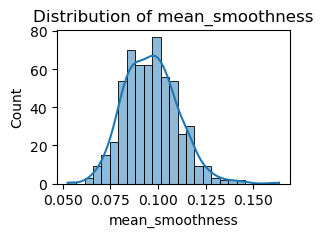

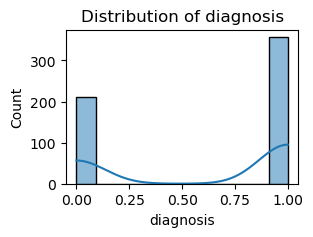

In [4]:
numeric_cols = data.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(3, 2))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [5]:
le = LabelEncoder()
for col in data.select_dtypes(include=['object']).columns:
    data[col] = le.fit_transform(data[col])

In [6]:

X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [17]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        self.value = value

class DecisionTreeClassifier():
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_info_gain = -float("inf")
        
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
           
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [11]:

dt = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
dt.fit(X_train, Y_train)
dt.print_tree()


X_3 <= 693.7 ? 0.26717546749140153
 left:X_4 <= 0.1102 ? 0.03845302840416545
  left:X_2 <= 85.24 ? 0.020427515320367046
    left:X_4 <= 0.1089 ? 0.001709541824055666
        left:X_1 <= 22.44 ? 0.0013286370980506307
                left:X_4 <= 0.09934 ? 0.0002092469875349997
                                left:1.0
                                right:1.0
                right:X_1 <= 22.47 ? 0.07306763285024176
                                left:0.0
                                right:1.0
        right:1.0
    right:X_1 <= 19.24 ? 0.08397618529795564
        left:X_4 <= 0.0997 ? 0.028799999999999992
                left:1.0
                right:X_0 <= 13.47 ? 0.12000000000000005
                                left:1.0
                                right:1.0
        right:X_4 <= 0.09245 ? 0.23282548476454307
                left:X_2 <= 86.18 ? 0.09421568627450999
                                left:0.0
                                right:1.0
                right:X_1 <= 24.9

In [ ]:
Y_pred = dt.predict(X_test)


In [ ]:
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average='macro') 
recall = recall_score(Y_test, Y_pred, average='macro')
conf_matrix = confusion_matrix(Y_test, Y_pred)

In [16]:
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Confusion Matrix:\n {conf_matrix}')


Accuracy: 0.9385964912280702
Precision: 0.9277759580740256
Recall: 0.9412162162162162
Confusion Matrix:
 [[38  2]
 [ 5 69]]


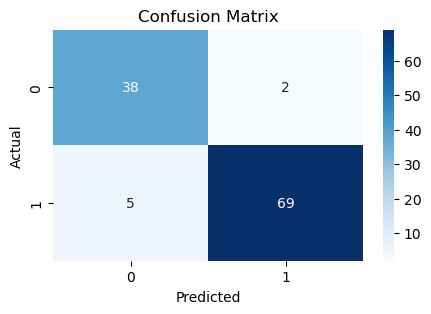

In [15]:

plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [13]:
fpr, tpr, _ = roc_curve(Y_test, Y_pred, pos_label=1)
roc_auc = auc(fpr, tpr)

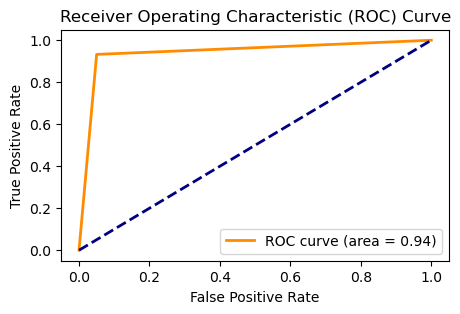

In [14]:
plt.figure(figsize=(5, 3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()